# Weather Forecasting using Auto-regressive Model

In this project Auto-regressive, a schotastic process is applied on a 248 years of weather data of Canada to capture the trend and seasonality and forecast temperature for future dates.

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
import warnings
from IPython.display import HTML

# At the time of writing, statsmodels didn't catchup with the latest pandas,
# so there are a few unwanted warnings we don't want to see here.
# Follow this instruction to ignore warnings: https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython

np.set_printoptions(threshold=np.inf)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

FILE_NAME = 'GlobalLandTemperaturesByCountry.csv'

## Load and prepare the data

This project works with a dataset saved into a `.csv` file. Let us load that up and perform required pre-processing.

In [2]:
df = pd.read_csv(FILE_NAME, sep=',', skipinitialspace=True, encoding='utf-8')
df = df[df['Country'] == 'Canada']

## Are we dealing with missing values? 

In [3]:
print(df.shape)
df = df[df.AverageTemperature.notnull()]
print(df.shape)

(2941, 4)
(2504, 4)


Clearly, there are 437 rows without a value. Now this can be handled in many ways. For simplicity's sake, `padding` is used which essentially means continuing with the last non-NaN value. 

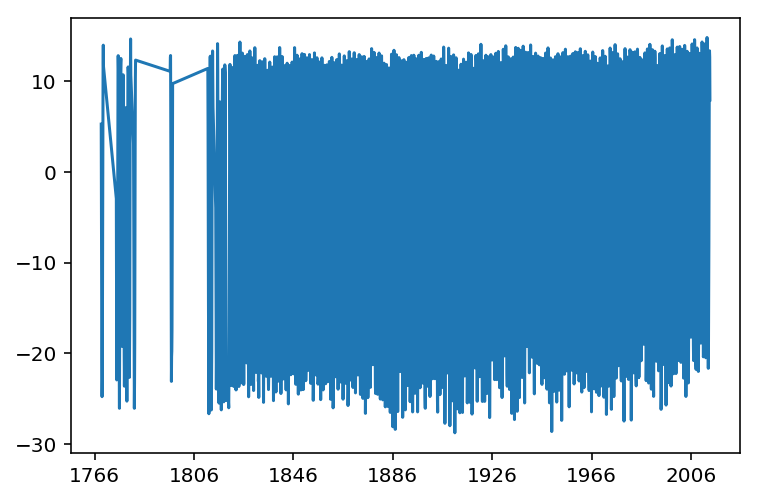

In [4]:
df.index = pd.to_datetime(df.dt)
df = df.drop(['dt', 'Country', 'AverageTemperatureUncertainty'], axis=1)
df = df.sort_index()
df.AverageTemperature.fillna(method='pad', inplace=True)
mp.plot(df.AverageTemperature)
mp.show()

Now the questions we need to ask, whether:
- Do we need more than 248 years of data? Past 113 years of data should be more than enough.
- Are the flat NaN values across many initial years contribute positively to our dataset? No, because we miss both trend and seasonality.

So, we are settling with data points from 1900 and onwards.

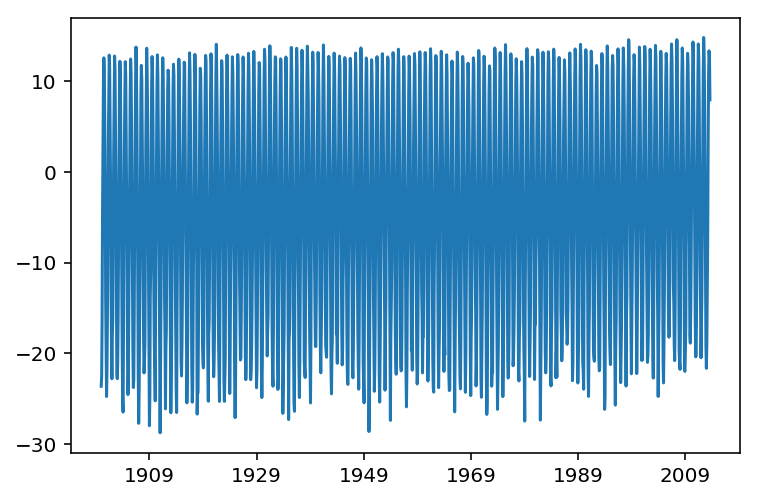

In [5]:
df = df.loc['1900-01-01':]
mp.plot(df.AverageTemperature)
mp.show()

## Seasonality
If we plot last 5-year instead of all the years as plotted above, clearly it is seen that there is a seasonality of the data points. Every year there is a pattern from the beginning of the year to the end due to the recurring seasons through out the year. 

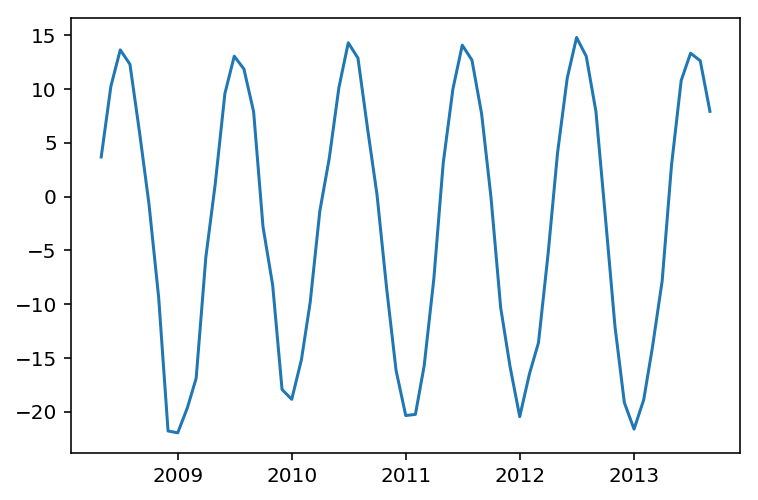

In [6]:
df_5yrs = df.loc['2008-05-01':]
mp.plot(df_5yrs.AverageTemperature)
mp.show()

## Rolling Mean/Moving Average
Running a rolling mean aka. moving average through the data is almost obligatory just to get a more comprehensive insight into the data. The rolling mean window is kept 12 just to signify that we are interested in 12-month data points per year.

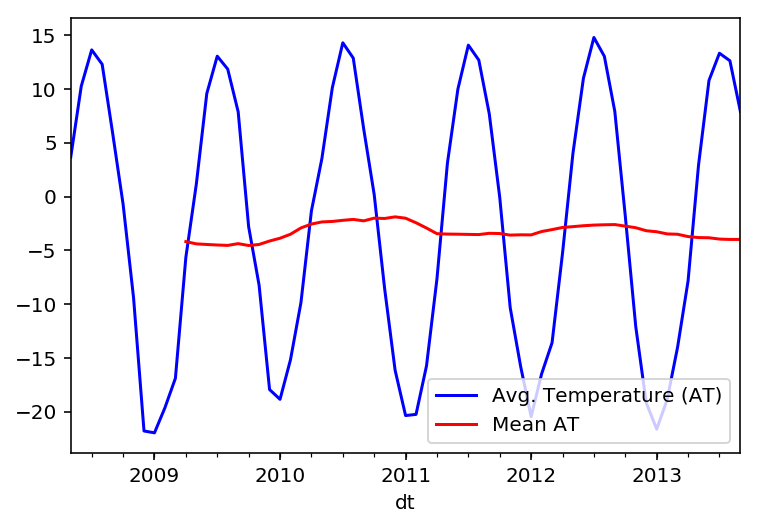

In [7]:
df_5yrs.AverageTemperature.plot.line(style='b', legend=True, label='Avg. Temperature (AT)')
ax = df_5yrs.AverageTemperature.rolling(window=12).mean().plot.line(style='r', legend=True, label='Mean AT')
mp.show()

## Stationarity
If the dataset has its key statistical properties unchanged over time such as mean value, the variance and the autocorrelation, it is said to be stationary. There is a test called Augmented Dickey–Fuller test, which helps to find stationary properties in a Time Series. 

In [8]:
def test_stationarity(df):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df)
    indices = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    output = pd.Series(dftest[0:4], index=indices)
    for key, value in dftest[4].items():
        output['Critical Value (%s)' % key] = value
    print(output)
    
test_stationarity(df.AverageTemperature)

Results of Dickey-Fuller Test:
Test Statistic                   -3.991544
p-value                           0.001455
#Lags Used                       24.000000
Number of Observations Used    1340.000000
Critical Value (1%)              -3.435239
Critical Value (5%)              -2.863699
Critical Value (10%)             -2.567920
dtype: float64


One way to interpret the results is that the Test Statistic here is lower than Critical Value (1%), so it can be concluded with 99% confidence that the Time Series is stationary. What to do if the Time Series is non-stationary? One way is to apply Autoregressive integrated moving average (ARIMA) to the series to make it stationary.

## Autoregressive–moving-average (ARMA) Model
A more detailed discussion on what the parameters are and how they are chosen can be found [here](http://tanzimsaqib.com/time-series-101).

In [9]:
print(arma_order_select_ic(df.AverageTemperature, ic=['aic', 'bic'], trend='nc',
            max_ar=4, max_ma=4, fit_kw={'method': 'css-mle'}))

{'aic':              0            1            2            3            4
0          NaN  9541.396072  8611.708384  8053.213790  7670.346779
1  9044.836471  8257.208512  7818.841614  8509.749884  7979.642028
2  7054.294644          NaN  6607.081457  6468.689982  6344.164296
3  6815.595289  6812.395189          NaN  5186.669394          NaN
4  6803.707387  6818.564252          NaN  5760.629858  5264.468155, 'bic':              0            1            2            3            4
0          NaN  9551.833892  8627.365113  8074.089428  7696.441328
1  9055.274290  8272.865241  7839.717253  8535.844432  8010.955486
2  7069.951373          NaN  6633.176005  6500.003441  6380.696664
3  6836.470928  6838.489737          NaN  5223.201762          NaN
4  6829.801936  6849.877710          NaN  5802.381136  5311.438342, 'aic_min_order': (3, 3), 'bic_min_order': (3, 3)}


## Fitting the Model and Forecasting next 10-year Weather

                               Results: ARMA
Model:                ARMA                 BIC:                   5223.2018 
Dependent Variable:   AverageTemperature   Log-Likelihood:        -2586.3   
Date:                 2017-06-07 14:39     Scale:                 1.0000    
No. Observations:     1365                 Method:                css-mle   
Df Model:             6                    Sample:                01-01-1900
Df Residuals:         1359                                        09-01-2013
Converged:            1.0000               S.D. of innovations:   1.600     
AIC:                  5186.6694            HQIC:                  5200.343  
----------------------------------------------------------------------------
                          Coef.  Std.Err.      t      P>|t|   [0.025  0.975]
----------------------------------------------------------------------------
ar.L1.AverageTemperature  2.7312   0.0000  63031.4634 0.0000  2.7311  2.7313
ar.L2.AverageTemperature -2.730

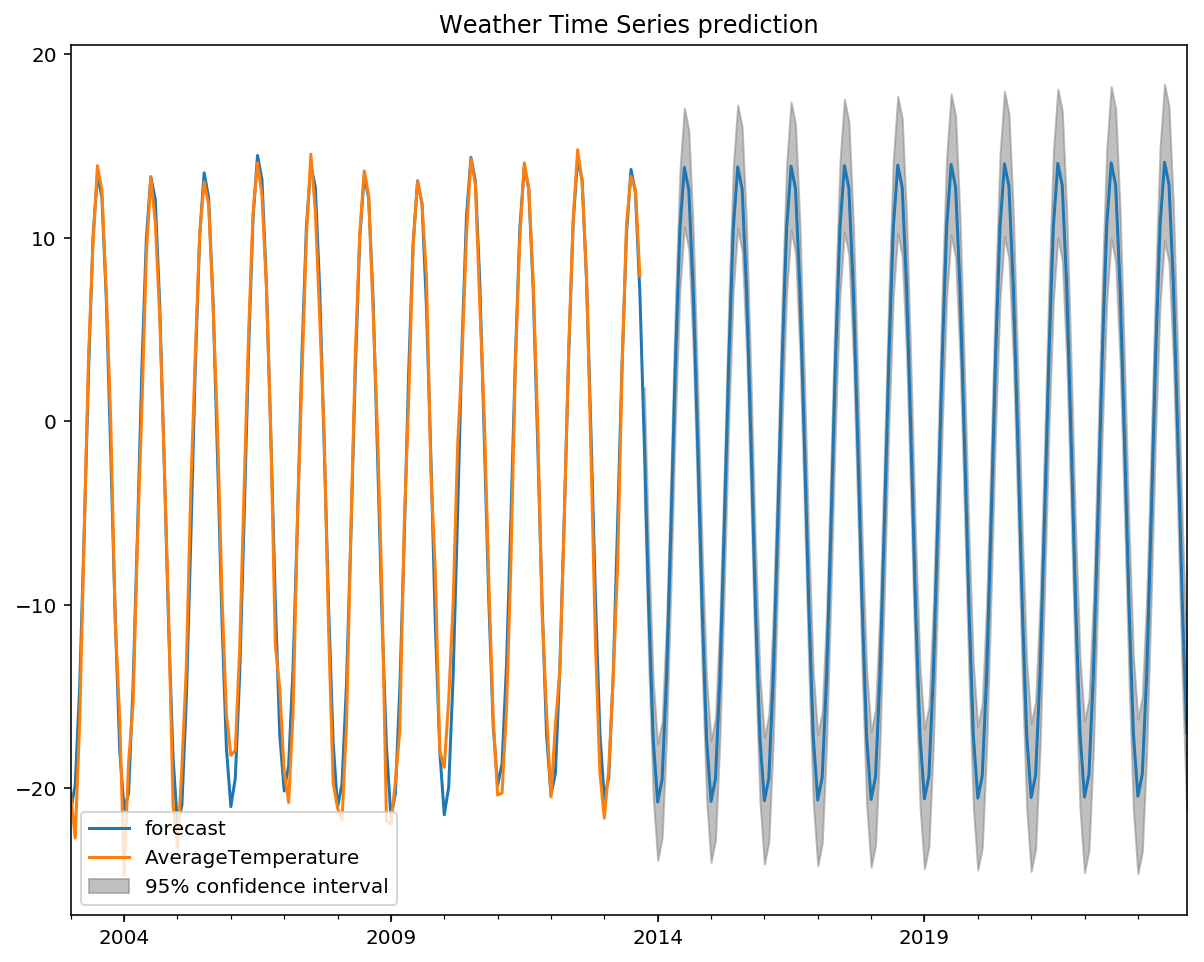

In [10]:
# Fit the model
ts = pd.Series(df.AverageTemperature, index=df.index)
model = ARMA(ts, order=(3, 3))
results = model.fit(trend='nc', method='css-mle')
print(results.summary2())

# Plot the model
fig, ax = mp.subplots(figsize=(10, 8))
fig = results.plot_predict('01/01/2003', '12/01/2023', ax=ax)
ax.legend(loc='lower left')
mp.title('Weather Time Series prediction')
mp.show()

predictions = results.predict('01/01/2003', '12/01/2023')
# You can manipulate/print the predictions after this

The forecast in `blue` color clearly depicts the weather forecasts of the future dates. The tutorial lives [here](http://tanzimsaqib.com/time-series-101).